In [1973]:
!pip install p3_data

In [1974]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [1975]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [1978]:
# Load result files from P3 Test Driver
src_files = []

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020

## attempt1 brokers out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/Pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-18tests-attempt1-broker-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt2 bookies out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt2-bk-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt3 broker out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results/*.json']
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results_cleared/*.json']

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020
## attempt4 broker out of direct memory - 52 tests
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-52tests-attempt4/data/p3_test_driver/results_cleared/*.json']

# pulsar-2.6.0-no-tiered-10.07.2020-46tests-success
src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-no-tiered-10.07.2020-46tests-success/data/p3_test_driver/results_cleared/*.json']
#---------------------------------------------------------

### Pulsar 2.5.2 15.06.2020 44 tests different amount of workers
# src_files += ['../../../../../tests/pulsar_2.5.2_44_tests_15.06/data/p3_test_driver/results/*.json']

### Pulsar 2.5.2 17.06.2020 44 tests different amount of workers
#src_files += ['../../../../../tests/Pulsar-2.5.2-17.06.20-44tests/data/p3_test_driver/results_cleared/*.json']

#-------------------------------------------------------------------------
# Pulsar fresh tests 2.5.2 
src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/Pulsar-2.5.2-no_tier2_11.07.2020/pulsar-2.5.2-10k_1p_16p_100b_1p_no_tier2_47tests-11.07.2020/data/p3_test_driver/results/*.json']



# Pravega 0.8.0-2577.15b0f5eb9 tier2 29.06.2020
#src_files += ['../../../../tests/pravega-15b0f5eb9-tier2-29.06.2020-10k-100b/pravega-0.8.0-2577.15b0f5eb9-tier2-10k-28tests-29.06.2020/data/p3_test_driver/results/*.json']

# pravega-0.8.0-2656.1c40f1e-no_netty_Isilon-nfs-tier2 09.07.2020 48 tests success
#src_files += ['../../../../../tests/Pravega-1c40f1e-NO_NETTY-nfs-Isilon-tier2-48tests-succsess-09.07.2020/data/p3_test_driver/results/*.json']

### PRAVEGA 15b0f5eb9 (master) Isilon nfs omb 2b28b32 (no_netty) 09.07.2020 48tests success
src_files += ['../../../../../tests/PRAVEGA-15b0f5eb9-Isilon-nfs-omb-2b28b32-09.07.2020-48tests/data/p3_test_driver/results/*.json']

###### PRAVEGA 15b0f5eb9 (master) omb 2b28b32 (no_netty) ECS S3 tier2
src_files += ['../../../../../tests/PRAVEGA-15b0f5eb9-2b28b32-ECS-tier2-13.07.2020/10k-1p/data/p3_test_driver/results/*.json']

raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 149 files...


In [1979]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '1c40f1e-no_netty_Isilon-nfs-tier2'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['consumeRateEventsPerSecMean'] = r['consumeRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['consumeRateMBPerSecMean'] = r['consumeRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        
        if r['driverName'] == 'Pulsar':
            r['version'] = r['pulsarVersion']
            
        if r['driverName'] == 'Pravega':    
            r['version'] = r['pravegaVersion']   
        
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [1980]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [1981]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [1982]:
# Show list of columns
clean_df.columns.values

array(['ackQuorum', 'aggregatedEndToEndLatency50pct',
       'aggregatedEndToEndLatency75pct', 'aggregatedEndToEndLatency95pct',
       'aggregatedEndToEndLatency9999pct',
       'aggregatedEndToEndLatency999pct',
       'aggregatedEndToEndLatency99pct', 'aggregatedEndToEndLatencyAvg',
       'aggregatedEndToEndLatencyMax',
       'aggregatedEndToEndLatencyQuantiles',
       'aggregatedPublishLatency50pct', 'aggregatedPublishLatency75pct',
       'aggregatedPublishLatency95pct', 'aggregatedPublishLatency9999pct',
       'aggregatedPublishLatency999pct', 'aggregatedPublishLatency99pct',
       'aggregatedPublishLatencyAvg', 'aggregatedPublishLatencyMax',
       'aggregatedPublishLatencyQuantiles', 'ansible', 'ansible_vars',
       'aws-ec2', 'backlog', 'bookkeeperVersion', 'build',
       'command_timed_out', 'consumeRate', 'consumeRateEventsPerSecMean',
       'consumeRateMBPerSecMean', 'consumeRateMean',
       'consumerBacklogSizeGB', 'consumerPerSubscription',
       'deduplicationE

In [1983]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'driverName',
    'version'
]

In [1984]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'consumeRateEventsPerSecMean',
    'consumeRateMBPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'throttleEventsPerSec',
    'utc_begin',    
]

In [1985]:
cols = param_cols + output_cols

In [1986]:
# View most recent results
clean_df[cols].tail(38).T

test_uuid                   b988c948-f418-4a87-b07d-f7ce41e78f0e  \
numWorkloadWorkers                                             4   
topics                                                         4   
partitionsPerTopic                                            16   
producersPerTopic                                              4   
subscriptionsPerTopic                                          1   
consumerPerSubscription                                        4   
testDurationMinutes                                            2   
keyDistributor                                            NO_KEY   
git_commit                                               1793eb2   
driverName                                                Pulsar   
version                                                    2.5.2   
publishRateEventsPerSecMean                              9029.94   
consumeRateEventsPerSecMean                              9030.28   
consumeRateMBPerSecMean                                  90.3028   
publishRateMBPerSecMean                                  90.2994   
publishLatencyMs50Pct                                      2.993   
publishLatencyMs99Pct                                    247.554   
endToEndLatencyMs50Pct                                         8   
endToEndLatencyMs99Pct                                       254   
throttleEventsPerSec                                        9000   
utc_begin                       2020-07-11 13:57:55.020426+00:00   

test_uuid                   67d39703-4661-40c4-8709-645539534c70  \
numWorkloadWorkers                                             4   
topics                                                         4   
partitionsPerTopic                                            16   
producersPerTopic                                              4   
subscriptionsPerTopic                                          1   
consumerPerSubscription                                        4   
testDurationMinutes                                            2   
keyDistributor                                            NO_KEY   
git_commit                                               1793eb2   
driverName                                                Pulsar   
version                                                    2.5.2   
publishRateEventsPerSecMean                              15071.1   
consumeRateEventsPerSecMean                              15071.4   
consumeRateMBPerSecMean                                  150.714   
publishRateMBPerSecMean                                  150.711   
publishLatencyMs50Pct                                      3.324   
publishLatencyMs99Pct                                    414.025   
endToEndLatencyMs50Pct                                         9   
endToEndLatencyMs99Pct                                   422.001   
throttleEventsPerSec                                       15000   
utc_begin                       2020-07-11 14:02:22.628781+00:00   

test_uuid                   f9d2f0f8-ad39-425a-942e-8b92e4a5bd86  \
numWorkloadWorkers                                             4   
topics                                                         4   
partitionsPerTopic                                            16   
producersPerTopic                                              4   
subscriptionsPerTopic                                          1   
consumerPerSubscription                                        4   
testDurationMinutes                                            2   
keyDistributor                                            NO_KEY   
git_commit                                               1793eb2   
driverName                                                Pulsar   
version                                                    2.5.2   
publishRateEventsPerSecMean                              30251.1   
consumeRateEventsPerSecMean                              30250.6   
consumeRateMBPerSecMean                               

In [1987]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [1988]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [1990]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['version']).size()

version
0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2    48
15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2              12
2.5.2                                                46
2.6.0-not-tiered                                     43
dtype: int64

In [1991]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
    #version='2.6.0-not-tiered',
    #driverName='Pulsar',
    #pulsarVersion='2.5.2',
    #pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2',
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

149

In [1992]:
def latency_vs_publish_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Publish Throughput (MB/s)'
    return result_df

In [1993]:
def latency_vs_consume_throughput_table(df):
    result_df = (df
        .set_index(['consumeRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Consume Throughput (MB/s)'
    return result_df

In [1994]:
def latency_vs_provided_rate_table(df):
    result_df = (df
        .set_index(['throttleEventsPerSec'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Throttle Events Per Second'
    return result_df

In [1995]:
def plot_latency_vs_consume_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_consume_throughput_table(df)
    title = '%s %s , message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [1996]:
def plot_latency_vs_publish_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_publish_throughput_table(df)
    title = '%s %s , message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [1997]:
def plot_latency_vs_provided_rate(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [1998]:
def plot_latency_vs_provided_rate_normal(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s , message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=False, 
        logy=False,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [1999]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producersPerTopic=4,
    partitionsPerTopic=16,
    version='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2',
    #version='2.6.0-not-tiered',
    #version='2.5.2',
    topics=4
)

In [2000]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

Empty DataFrame
Columns: []
Index: []

In [2001]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid                             68ffebf8-bae2-4189-b5ff-9404ef99d874
numWorkloadWorkers                                                       4
topics                                                                   4
partitionsPerTopic                                                      16
producersPerTopic                                                        4
subscriptionsPerTopic                                                    1
consumerPerSubscription                                                  4
testDurationMinutes                                                      2
keyDistributor                                                      NO_KEY
git_commit                                                         88dbf86
driverName                                                         Pravega
version                  0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2

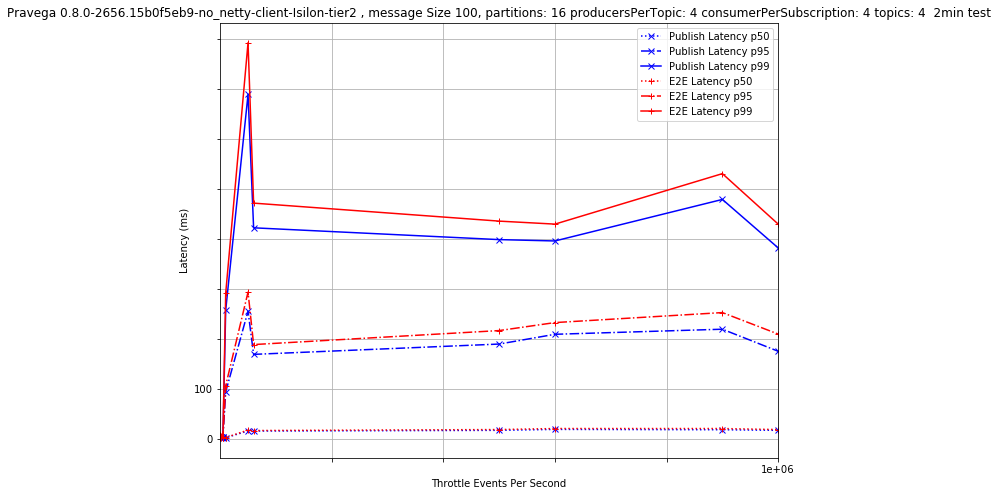

In [2002]:
plot_latency_vs_provided_rate_normal(filt_100_df)

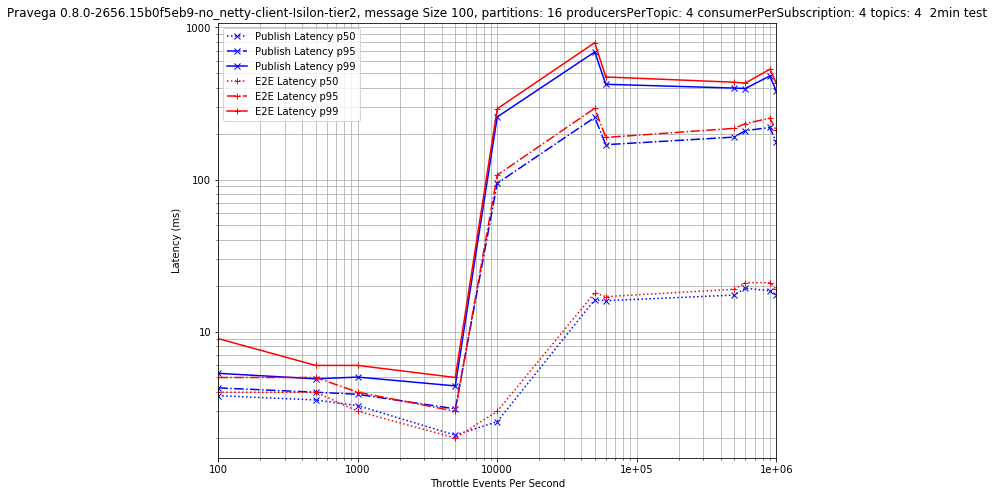

In [2003]:
plot_latency_vs_provided_rate(filt_100_df)

In [2004]:
latency_vs_provided_rate_table(filt_100_df)

Publish Latency p50  Publish Latency p95  \
Throttle Events Per Second                                             
100.0                                     3.797                4.272   
500.0                                     3.557                4.001   
1000.0                                    3.268                3.875   
5000.0                                    2.089                3.110   
10000.0                                   2.563               94.469   
50000.0                                  16.221              255.930   
60000.0                                  15.972              169.392   
500000.0                                 17.401              190.029   
600000.0                                 19.297              209.575   
900000.0                                 18.593              219.728   
1000000.0                                17.391              175.603   

                            Publish Latency p99  E2E Latency p50  \
Throttle Events Per Second                                         
100.0                                     5.325              4.0   
500.0                                     4.899              4.0   
1000.0                                    5.031              3.0   
5000.0                                    4.402              2.0   
10000.0                                 257.903              3.0   
50000.0                                 689.479             18.0   
60000.0                                 422.597             17.0   
500000.0                                399.007             19.0   
600000.0                                396.295             21.0   
900000.0                                479.385             21.0   
1000000.0                               382.401             19.0   

                            E2E Latency p95  E2E Latency p99  \
Throttle Events Per Second                                     
100.0                                 5.000            9.000   
500.0                                 5.000            6.000   
1000.0                                4.000            6.000   
5000.0                                3.000            5.000   
10000.0                             107.000          292.001   
50000.0                             294.001          793.003   
60000.0                             189.000          472.001   
500000.0                            217.000          436.001   
600000.0                            233.000          430.001   
900000.0                            253.000          531.003   
1000000.0                           210.000          430.001   

                                                       test_uuid  
Throttle Events Per Second                                        
100.0                       c202bfac-00dc-4caa-b769-59ca8d86d45a  
500.0                       7c4e6a3f-c0ce-4dbe-8c22-5b97bef0d3b1  
1000.0                      3ae6f705-f582-4662-842d-552bae82daf2  
5000.0                      ffa737b9-c7d4-4b98-b852-49ac9390806f  
10000.0                     43d23720-4b21-4cbe-b246-86985892a3aa  
50000.0                     ffd6ca94-17ef-456a-a0bf-7c215606fb5e  
60000.0                     77eab127-c0cd-4a09-88f8-cfbb3da106ea  
500000.0                    f306de9a-9931-4887-9549-e4d1d18323b3  
600000.0                    63cf6351-3545-4275-8565-fa083e343f06  
900000.0                    d8535c88-4a9c-4a6f-b885-c8418587a51c  
1000000.0                   68ffebf8-bae2-4189-b5ff-9404ef99d874

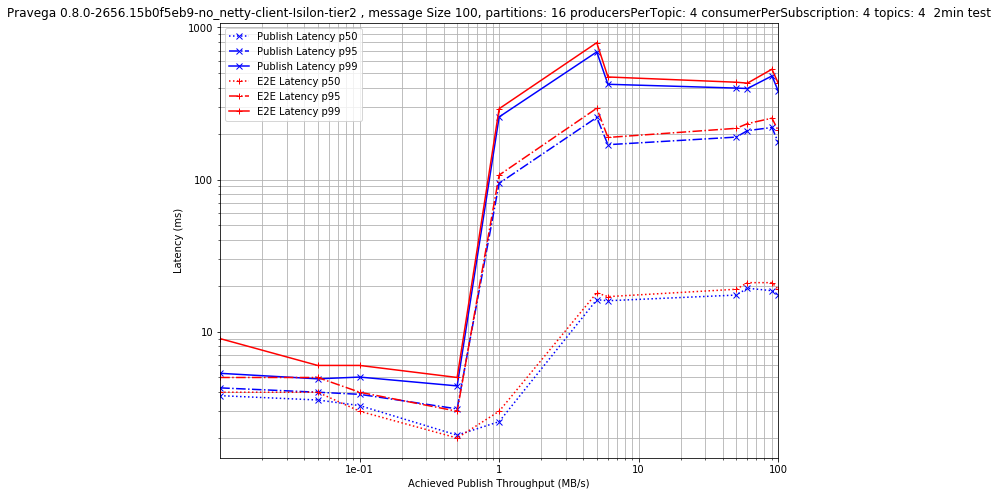

In [2005]:
plot_latency_vs_publish_throughput(filt_100_df)

In [2006]:
latency_vs_publish_throughput_table(filt_100_df)

Publish Latency p50  Publish Latency p95  \
Achieved Publish Throughput (MB/s)                                             
0.010015                                          3.797                4.272   
0.050083                                          3.557                4.001   
0.100174                                          3.268                3.875   
0.500689                                          2.089                3.110   
1.001685                                          2.563               94.469   
5.017857                                         16.221              255.930   
6.035034                                         15.972              169.392   
50.140098                                        17.401              190.029   
60.389950                                        19.297              209.575   
90.511950                                        18.593              219.728   
100.292336                                       17.391              175.603   

                                    Publish Latency p99  E2E Latency p50  \
Achieved Publish Throughput (MB/s)                                         
0.010015                                          5.325              4.0   
0.050083                                          4.899              4.0   
0.100174                                          5.031              3.0   
0.500689                                          4.402              2.0   
1.001685                                        257.903              3.0   
5.017857                                        689.479             18.0   
6.035034                                        422.597             17.0   
50.140098                                       399.007             19.0   
60.389950                                       396.295             21.0   
90.511950                                       479.385             21.0   
100.292336                                      382.401             19.0   

                                    E2E Latency p95  E2E Latency p99  \
Achieved Publish Throughput (MB/s)                                     
0.010015                                      5.000            9.000   
0.050083                                      5.000            6.000   
0.100174                                      4.000            6.000   
0.500689                                      3.000            5.000   
1.001685                                    107.000          292.001   
5.017857                                    294.001          793.003   
6.035034                                    189.000          472.001   
50.140098                                   217.000          436.001   
60.389950                                   233.000          430.001   
90.511950                                   253.000          531.003   
100.292336                                  210.000          430.001   

                                                               test_uuid  
Achieved Publish Throughput (MB/s)                                        
0.010015                            c202bfac-00dc-4caa-b769-59ca8d86d45a  
0.050083                            7c4e6a3f-c0ce-4dbe-8c22-5b97bef0d3b1  
0.100174                            3ae6f705-f582-4662-842d-552bae82daf2  
0.500689                            ffa737b9-c7d4-4b98-b852-49ac9390806f  
1.001685                            43d23720-4b21-4cbe-b246-86985892a3aa  
5.017857                            ffd6ca94-17ef-456a-a0bf-7c215606fb5e  
6.035034                            77eab127-c0cd-4a09-88f8-cfbb3da106ea  
50.140098                           f306de9a-9931-4887-9549-e4d1d18323b3  
60.389950                           63cf6351-3545-4275-8565-fa083e343f06  
90.511950                           d8535c88-4a9c-4a6f-b885-c8418587a51c  
100.292336                          68ffebf8-bae2-4189-b5ff-9404ef99d874

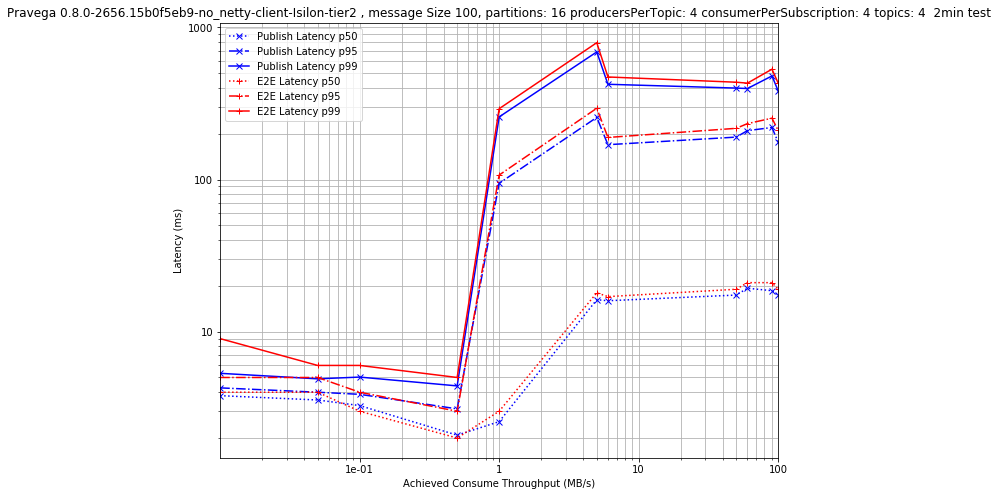

In [2007]:
plot_latency_vs_consume_throughput(filt_100_df)

In [2008]:
latency_vs_consume_throughput_table(filt_100_df)

Publish Latency p50  Publish Latency p95  \
Achieved Consume Throughput (MB/s)                                             
0.010014                                          3.797                4.272   
0.050052                                          3.557                4.001   
0.100170                                          3.268                3.875   
0.500709                                          2.089                3.110   
1.001750                                          2.563               94.469   
5.018681                                         16.221              255.930   
6.034468                                         15.972              169.392   
50.139025                                        17.401              190.029   
60.390060                                        19.297              209.575   
90.513217                                        18.593              219.728   
100.293165                                       17.391              175.603   

                                    Publish Latency p99  E2E Latency p50  \
Achieved Consume Throughput (MB/s)                                         
0.010014                                          5.325              4.0   
0.050052                                          4.899              4.0   
0.100170                                          5.031              3.0   
0.500709                                          4.402              2.0   
1.001750                                        257.903              3.0   
5.018681                                        689.479             18.0   
6.034468                                        422.597             17.0   
50.139025                                       399.007             19.0   
60.390060                                       396.295             21.0   
90.513217                                       479.385             21.0   
100.293165                                      382.401             19.0   

                                    E2E Latency p95  E2E Latency p99  \
Achieved Consume Throughput (MB/s)                                     
0.010014                                      5.000            9.000   
0.050052                                      5.000            6.000   
0.100170                                      4.000            6.000   
0.500709                                      3.000            5.000   
1.001750                                    107.000          292.001   
5.018681                                    294.001          793.003   
6.034468                                    189.000          472.001   
50.139025                                   217.000          436.001   
60.390060                                   233.000          430.001   
90.513217                                   253.000          531.003   
100.293165                                  210.000          430.001   

                                                               test_uuid  
Achieved Consume Throughput (MB/s)                                        
0.010014                            c202bfac-00dc-4caa-b769-59ca8d86d45a  
0.050052                            7c4e6a3f-c0ce-4dbe-8c22-5b97bef0d3b1  
0.100170                            3ae6f705-f582-4662-842d-552bae82daf2  
0.500709                            ffa737b9-c7d4-4b98-b852-49ac9390806f  
1.001750                            43d23720-4b21-4cbe-b246-86985892a3aa  
5.018681                            ffd6ca94-17ef-456a-a0bf-7c215606fb5e  
6.034468                            77eab127-c0cd-4a09-88f8-cfbb3da106ea  
50.139025                           f306de9a-9931-4887-9549-e4d1d18323b3  
60.390060                           63cf6351-3545-4275-8565-fa083e343f06  
90.513217                           d8535c88-4a9c-4a6f-b885-c8418587a51c  
100.293165                          68ffebf8-bae2-4189-b5ff-9404ef99d874

## Message Size 10 KB

In [2010]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
    producersPerTopic=4,
    partitionsPerTopic=1,
    numWorkloadWorkers=4,
    #version='2.6.0-not-tiered'
    #version='2.5.2',
    #version='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2'
    version='15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2'
)

In [2011]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid                   ea38528f-b44a-411b-ab21-05df7ab46bba
numWorkloadWorkers                                             4
topics                                                         4
partitionsPerTopic                                             1
producersPerTopic                                              4
subscriptionsPerTopic                                          1
consumerPerSubscription                                        4
testDurationMinutes                                            2
keyDistributor                                            NO_KEY
git_commit                                               36327d9
driverName                                               Pravega
version                  15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2

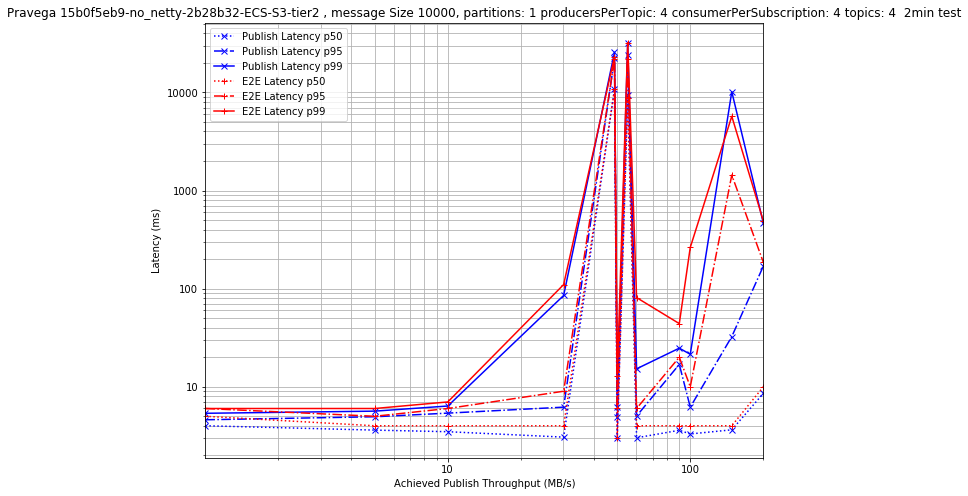

In [2012]:
plot_latency_vs_publish_throughput(filt_10000_df)

In [2013]:
latency_vs_publish_throughput_table(filt_10000_df)

Publish Latency p50  Publish Latency p95  \
Achieved Publish Throughput (MB/s)                                             
1.001562                                          4.003                4.605   
5.005481                                          3.613                4.943   
10.014787                                         3.480                5.382   
30.087920                                         3.065                6.194   
48.769276                                     10721.279            22184.447   
50.075737                                         3.016                4.922   
55.288071                                      9373.055            23859.071   
60.155225                                         3.017                5.028   
90.238519                                         3.599               16.895   
100.148651                                        3.301                6.190   
148.559063                                        3.638               32.439   
200.534677                                        8.559              169.670   

                                    Publish Latency p99  E2E Latency p50  \
Achieved Publish Throughput (MB/s)                                         
1.001562                                          5.362            5.000   
5.005481                                          5.639            4.000   
10.014787                                         6.360            4.000   
30.087920                                        85.131            4.000   
48.769276                                     25600.639        10748.031   
50.075737                                         6.208            3.000   
55.288071                                     32100.735         8837.055   
60.155225                                        15.226            4.000   
90.238519                                        24.720            4.000   
100.148651                                       21.425            4.000   
148.559063                                    10155.711            4.000   
200.534677                                      463.901           10.000   

                                    E2E Latency p95  E2E Latency p99  \
Achieved Publish Throughput (MB/s)                                     
1.001562                                      6.000            6.000   
5.005481                                      5.000            6.000   
10.014787                                     6.000            7.000   
30.087920                                     9.000          110.000   
48.769276                                 21976.063        23178.111   
50.075737                                     6.000           13.000   
55.288071                                 21932.031        32119.039   
60.155225                                     6.000           81.000   
90.238519                                    20.000           44.000   
100.148651                                   10.000          263.001   
148.559063                                 1438.007         5709.023   
200.534677                                  185.000          488.001   

                                                               test_uuid  
Achieved Publish Throughput (MB/s)                                        
1.001562                            ea38528f-b44a-411b-ab21-05df7ab46bba  
5.005481                            f22cf293-8453-4b3a-9111-6d38ba65a6fd  
10.014787                           edab4c5c-b5d3-4b88-92a5-24aec67ad3dd  
30.087920                           642396d8-fcba-4e84-a935-a0c642a95b6b  
48.769276                           67e52b00-e594-45ae-a276-33f7757e54bb  
50.075737                           a86f51f4-fefd-4296-9618-6dcfba34cb44  
55.288071                           739a51ee-d53a-4206-8067-54959d14d0d3  
60.155225                           e95c2eec-dad4-4fbc-bf7a-1e7e9ed17a6b  
90.238519                           edb371e3-0d72-429f-996d-0c8a899df654  
100.148651      

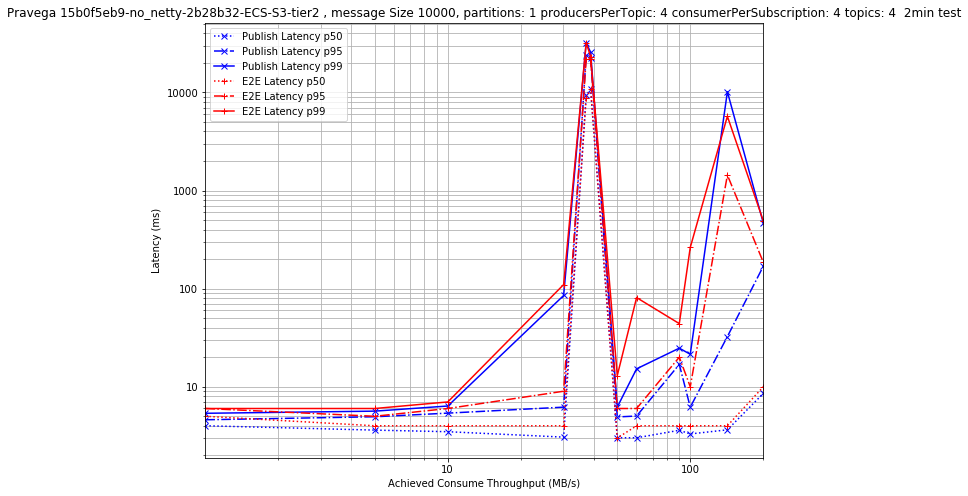

In [2014]:
plot_latency_vs_consume_throughput(filt_10000_df)

In [2015]:
latency_vs_consume_throughput_table(filt_10000_df)

Publish Latency p50  Publish Latency p95  \
Achieved Consume Throughput (MB/s)                                             
1.001480                                          4.003                4.605   
5.005646                                          3.613                4.943   
10.015117                                         3.480                5.382   
30.087923                                         3.065                6.194   
37.270274                                      9373.055            23859.071   
38.875382                                     10721.279            22184.447   
50.075327                                         3.016                4.922   
60.156219                                         3.017                5.028   
90.239856                                         3.599               16.895   
100.146012                                        3.301                6.190   
142.470506                                        3.638               32.439   
200.533672                                        8.559              169.670   

                                    Publish Latency p99  E2E Latency p50  \
Achieved Consume Throughput (MB/s)                                         
1.001480                                          5.362            5.000   
5.005646                                          5.639            4.000   
10.015117                                         6.360            4.000   
30.087923                                        85.131            4.000   
37.270274                                     32100.735         8837.055   
38.875382                                     25600.639        10748.031   
50.075327                                         6.208            3.000   
60.156219                                        15.226            4.000   
90.239856                                        24.720            4.000   
100.146012                                       21.425            4.000   
142.470506                                    10155.711            4.000   
200.533672                                      463.901           10.000   

                                    E2E Latency p95  E2E Latency p99  \
Achieved Consume Throughput (MB/s)                                     
1.001480                                      6.000            6.000   
5.005646                                      5.000            6.000   
10.015117                                     6.000            7.000   
30.087923                                     9.000          110.000   
37.270274                                 21932.031        32119.039   
38.875382                                 21976.063        23178.111   
50.075327                                     6.000           13.000   
60.156219                                     6.000           81.000   
90.239856                                    20.000           44.000   
100.146012                                   10.000          263.001   
142.470506                                 1438.007         5709.023   
200.533672                                  185.000          488.001   

                                                               test_uuid  
Achieved Consume Throughput (MB/s)                                        
1.001480                            ea38528f-b44a-411b-ab21-05df7ab46bba  
5.005646                            f22cf293-8453-4b3a-9111-6d38ba65a6fd  
10.015117                           edab4c5c-b5d3-4b88-92a5-24aec67ad3dd  
30.087923                           642396d8-fcba-4e84-a935-a0c642a95b6b  
37.270274                           739a51ee-d53a-4206-8067-54959d14d0d3  
38.875382                           67e52b00-e594-45ae-a276-33f7757e54bb  
50.075327                           a86f51f4-fefd-4296-9618-6dcfba34cb44  
60.156219                           e95c2eec-dad4-4fbc-bf7a-1e7e9ed17a6b  
90.239856                           edb371e3-0d72-429f-996d-0c8a899df654  
100.146012      

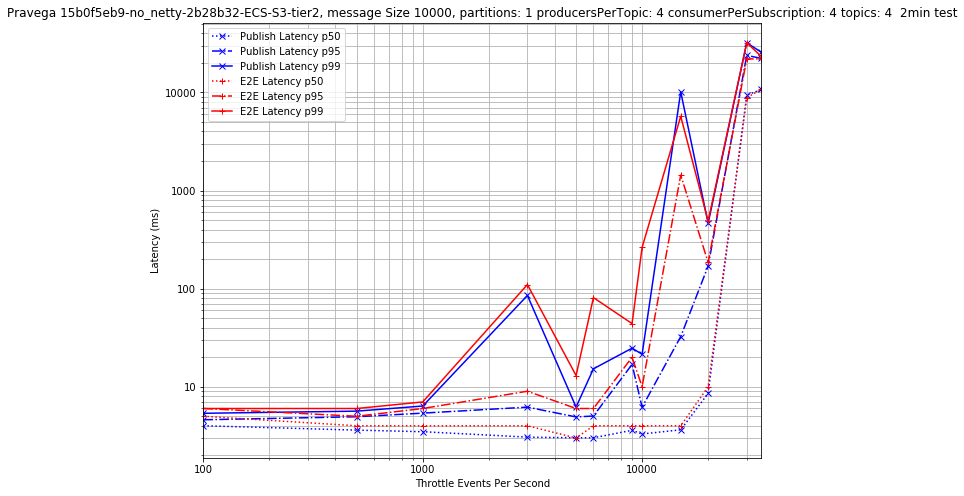

In [2016]:
plot_latency_vs_provided_rate(filt_10000_df)

In [2017]:
latency_vs_provided_rate_table(filt_10000_df)

Publish Latency p50  Publish Latency p95  \
Throttle Events Per Second                                             
100.0                                     4.003                4.605   
500.0                                     3.613                4.943   
1000.0                                    3.480                5.382   
3000.0                                    3.065                6.194   
5000.0                                    3.016                4.922   
6000.0                                    3.017                5.028   
9000.0                                    3.599               16.895   
10000.0                                   3.301                6.190   
15000.0                                   3.638               32.439   
20000.0                                   8.559              169.670   
30000.0                                9373.055            23859.071   
35000.0                               10721.279            22184.447   

                            Publish Latency p99  E2E Latency p50  \
Throttle Events Per Second                                         
100.0                                     5.362            5.000   
500.0                                     5.639            4.000   
1000.0                                    6.360            4.000   
3000.0                                   85.131            4.000   
5000.0                                    6.208            3.000   
6000.0                                   15.226            4.000   
9000.0                                   24.720            4.000   
10000.0                                  21.425            4.000   
15000.0                               10155.711            4.000   
20000.0                                 463.901           10.000   
30000.0                               32100.735         8837.055   
35000.0                               25600.639        10748.031   

                            E2E Latency p95  E2E Latency p99  \
Throttle Events Per Second                                     
100.0                                 6.000            6.000   
500.0                                 5.000            6.000   
1000.0                                6.000            7.000   
3000.0                                9.000          110.000   
5000.0                                6.000           13.000   
6000.0                                6.000           81.000   
9000.0                               20.000           44.000   
10000.0                              10.000          263.001   
15000.0                            1438.007         5709.023   
20000.0                             185.000          488.001   
30000.0                           21932.031        32119.039   
35000.0                           21976.063        23178.111   

                                                       test_uuid  
Throttle Events Per Second                                        
100.0                       ea38528f-b44a-411b-ab21-05df7ab46bba  
500.0                       f22cf293-8453-4b3a-9111-6d38ba65a6fd  
1000.0                      edab4c5c-b5d3-4b88-92a5-24aec67ad3dd  
3000.0                      642396d8-fcba-4e84-a935-a0c642a95b6b  
5000.0                      a86f51f4-fefd-4296-9618-6dcfba34cb44  
6000.0                      e95c2eec-dad4-4fbc-bf7a-1e7e9ed17a6b  
9000.0                      edb371e3-0d72-429f-996d-0c8a899df654  
10000.0                     09fe3ce4-1ea2-4c2f-a41a-5998a9e70027  
15000.0                     71e215c9-5d8c-42f2-9325-8e4251640621  
20000.0                     dc528009-7866-4efd-ac9e-f02b80302841  
30000.0                     739a51ee-d53a-4206-8067-54959d14d0d3  
35000.0                     67e52b00-e594-45ae-a276-33f7757e54bb

## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [1963]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

filter_dataframe: No matching records after filtering on producerRate=[-1]


0

In [1964]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

Empty DataFrame
Columns: []
Index: []

# Analyze Latency Distribution

In [1775]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

IndexError: single positional indexer is out-of-bounds

In [1683]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

IndexError: single positional indexer is out-of-bounds

In [1684]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

In [1685]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

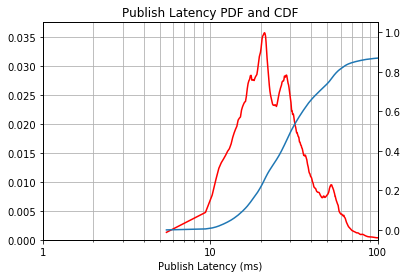

In [1686]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [1687]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

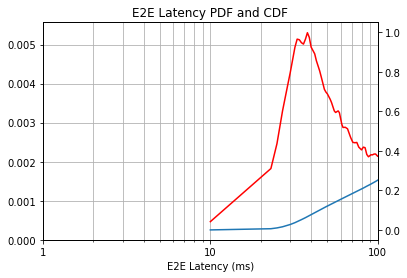

In [1688]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

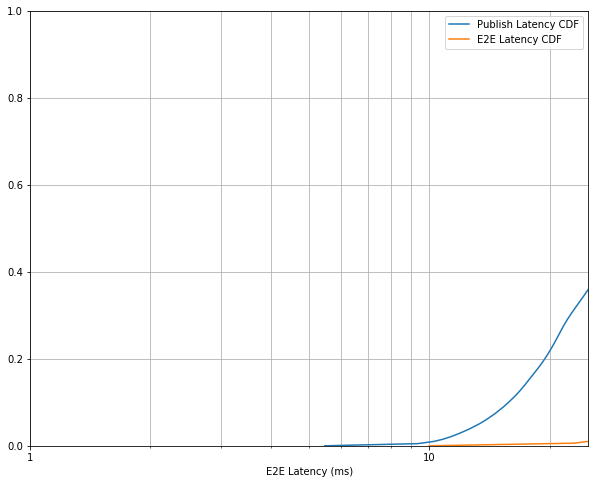

In [1689]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [1693]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
    #size_of_test_batch=(2,1000), # between
    #aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=10000,
    producersPerTopic=4,
    partitionsPerTopic=16,    
)
len(filt_df)

25

In [1694]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    version='2.6.0-not-tiered',
    #pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2' 
    #pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
)
len(filt1_df)

12

In [1695]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    #version='2.6.0-ecs-s3-tier2'
    version='2.5.2',
    #pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
)
len(filt2_df)

13

In [1696]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

git_commit           version
test_uuid                                                        
8ab39902-5742-41e1-a00b-ce423466273c    712d559  2.6.0-not-tiered
ca6c67ac-af4f-4cf7-aa22-223f7cf775af    1793eb2             2.5.2

In [1697]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    pravegaVersion = filt1_df.version.iloc[0]
    pravegaDriver = filt1_df.driver.iloc[0]
    pulsarVersion = filt2_df.version.iloc[0]
    pulsaraDriver = filt2_df.driver.iloc[0]
    messageSize = filt2_df.messageSize.iloc[0]
    msgSize = '%db' % (messageSize)
    if messageSize >= 1000:
        msgSize = '%dk' % (messageSize/1000)
    
    partitionsPerTopic = filt2_df.partitionsPerTopic.iloc[0]
    testDurationMinutes = filt2_df.testDurationMinutes.iloc[0]
    topics = filt2_df.topics.iloc[0]
    producersPerTopic = filt2_df.producersPerTopic.iloc[0]
    consumerPerSubscription = filt2_df.consumerPerSubscription.iloc[0]
    
    title = 'Compare %s %s and %s %s [messageSize %s, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %d min test' % (pravegaDriver, pravegaVersion, pulsaraDriver, pulsarVersion, msgSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
   
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
    
        plot_df = latency_vs_provided_rate_table(df)
        
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Achieved Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

In [1698]:
def plot_latency_vs_provided_rate_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    pravegaVersion = filt1_df.version.iloc[0]
    pravegaDriver = filt1_df.driver.iloc[0]
    pulsarVersion = filt2_df.version.iloc[0]
    pulsaraDriver = filt2_df.driver.iloc[0]
    messageSize = filt2_df.messageSize.iloc[0]
    msgSize = '%db' % (messageSize)
    if messageSize >= 1000:
        msgSize = '%dk' % (messageSize/1000)
    
    partitionsPerTopic = filt2_df.partitionsPerTopic.iloc[0]
    testDurationMinutes = filt2_df.testDurationMinutes.iloc[0]
    topics = filt2_df.topics.iloc[0]
    producersPerTopic = filt2_df.producersPerTopic.iloc[0]
    consumerPerSubscription = filt2_df.consumerPerSubscription.iloc[0]
    
    title = 'Compare %s %s and %s %s [messageSize %s, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %d min test' % (pravegaDriver, pravegaVersion, pulsaraDriver, pulsarVersion, msgSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['throttleEventsPerSec']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
               
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Provided Rate (Events/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

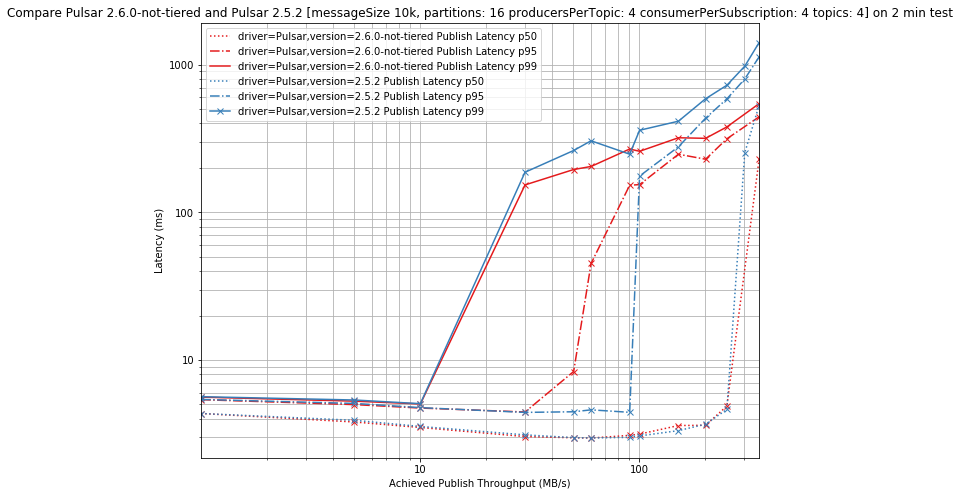

In [1699]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

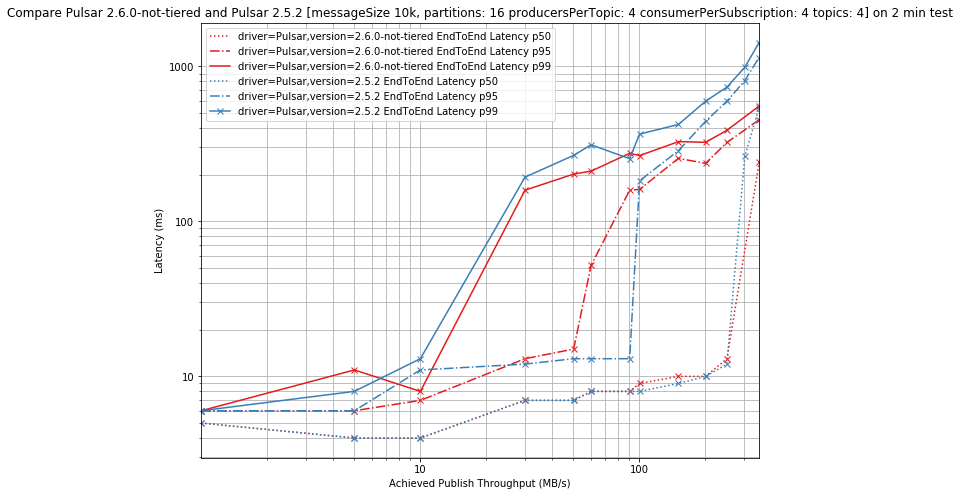

In [1700]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')

In [1701]:
### Latency vs Provided Rate 

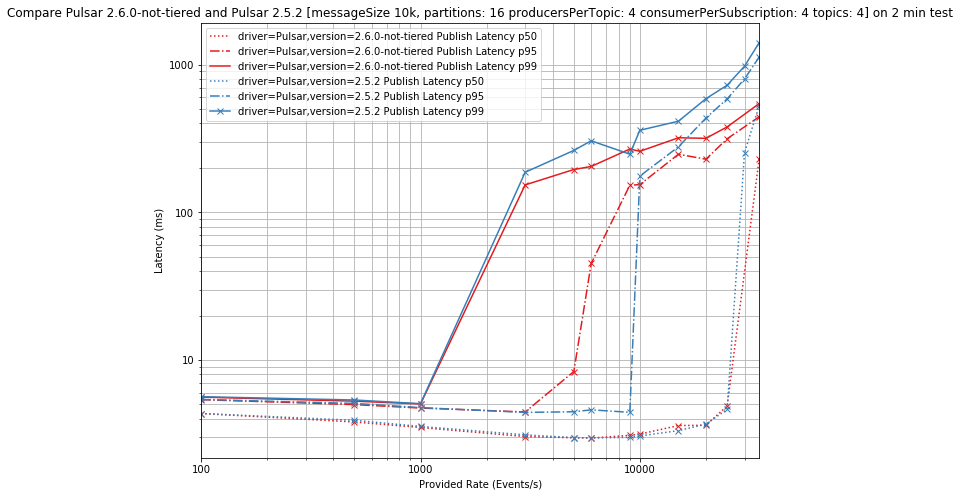

In [1702]:
plot_latency_vs_provided_rate_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

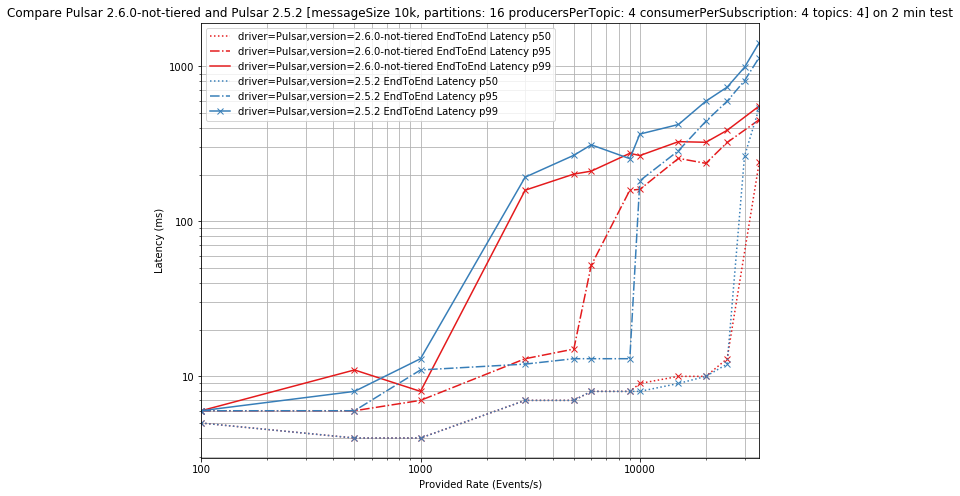

In [1703]:
plot_latency_vs_provided_rate_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')